In [1]:
import numpy as np
import pandas as pd
import librosa
import math

from IPython.display import Audio
import librosa.display
import os.path as osp
import librosa.util as util
import librosa.sequence as sequence
import scipy
from librosa.feature import melspectrogram
from librosa import core

import matplotlib.pyplot as plt

In [2]:
min_words = 40
wavs_dir = "C:/Users/yagne/Downloads/mp3s/"
target_sr = 16000
transcripts_path = "../outputs/all_transcripts_v2.csv"
transcripts = pd.read_csv(transcripts_path)


def play_audio(signal, rate):
    return Audio(data=signal, rate=rate)

In [3]:
data = (
    transcripts.loc[
        (transcripts["word_count"] >= min_words)
        & (transcripts["speaker_role"] == "scotus_justice")
    ]
    .copy()
    .reset_index(drop=True)
)

In [4]:
sample_1 = dict(data.iloc[827])

wav_file, wav_sr = librosa.load(
    path=osp.join(wavs_dir, f"{sample_1['file']}.mp3"),
    sr=librosa.core.get_samplerate(osp.join(wavs_dir, f"{sample_1['file']}.mp3")),
)
print("Speaker:", sample_1["speaker"])
print("File - Line", sample_1["file"], "-", sample_1["line"])
print("Duration:", sample_1["duration"])
print("Text:", sample_1["text"])
start_idx = math.floor(wav_sr * sample_1["start"])
end_idx = math.ceil(wav_sr * sample_1["end"])
clip = wav_file[start_idx:end_idx]
play_audio(clip, wav_sr)

C:\Users\yagne\.conda\envs\grandstanding\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Speaker: Anthony_M_Kennedy
File - Line 12-315 - 21
Duration: 11.308
Text: What -- what position -- although they'll tell us in a minute -- does Respondent take on that issue that a determination by the jury suffices? As you understand their brief. They can talk for themselves in a few minutes.


In [5]:
y = clip
sr = wav_sr
S = None
n_fft = 2048
hop_length = 512
lag = 1
max_size = 1
ref = None
detrend = False
center = True
feature = None
aggregate = None
channels = None
kwargs = {}

In [6]:
# Onset
super_o_env = librosa.onset.onset_strength(clip, sr=wav_sr, max_size=10)
super_times = librosa.frames_to_time(np.arange(len(super_o_env)), sr=wav_sr)
super_onset_frames = librosa.onset.onset_detect(
    onset_envelope=super_o_env, sr=wav_sr, units="time"
)

spec_o_env = librosa.onset.onset_strength(clip, sr=wav_sr, max_size=1)
spec_times = librosa.frames_to_time(np.arange(len(spec_o_env)), sr=wav_sr)
spec_onset_frames = librosa.onset.onset_detect(
    onset_envelope=spec_o_env, sr=wav_sr, units="time"
)

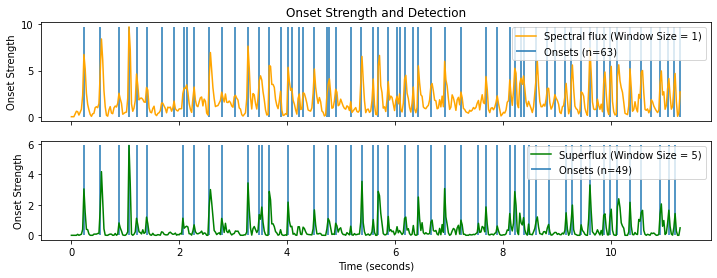

In [7]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12, 4))

frame_time = librosa.frames_to_time(
    np.arange(len(super_o_env)), sr=sr, hop_length=hop_length
)


ax[0].plot(
    frame_time, spec_o_env, color="orange", label="Spectral flux (Window Size = 1)"
)
ax[0].vlines(
    spec_onset_frames, 0, spec_o_env.max(), label=f"Onsets (n={len(spec_onset_frames)})"
)
ax[0].legend(loc="upper right")
ax[0].set_ylabel("Onset Strength")
ax[0].label_outer()

ax[1].plot(frame_time, super_o_env, color="g", label="Superflux (Window Size = 5)")
ax[1].vlines(
    super_onset_frames,
    0,
    super_o_env.max(),
    label=f"Onsets (n={len(super_onset_frames)})",
)
ax[1].legend(loc="upper right")
ax[1].set_ylabel("Onset Strength")
ax[1].set_xlabel("Time (seconds)")
ax[0].set_title("Onset Strength and Detection")
ax[0].label_outer()

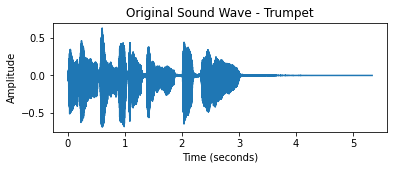

In [8]:
y, sr = librosa.load(librosa.ex("trumpet"))
times = np.arange(len(y)) / sr
plt.figure(figsize=(6, 2))
plt.plot(times, y)
plt.title("Original Sound Wave - Trumpet")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

In [9]:
S = None
lag = 1
max_size = 5
ref = None
detrend = False
center = True
feature = None
aggregate = None
kwargs = {}

In [10]:
if aggregate is False:
    raise ParameterError(
        "aggregate={} cannot be False when computing full-spectrum onset strength."
    )

In [11]:
if feature is None:
    feature = melspectrogram
    kwargs.setdefault("fmax", 11025.0)

if aggregate is None:
    aggregate = np.mean

if lag < 1 or not isinstance(lag, (int, np.integer)):
    raise ParameterError("lag must be a positive integer")

if max_size < 1 or not isinstance(max_size, (int, np.integer)):
    raise ParameterError("max_size must be a positive integer")

# First, compute mel spectrogram
if S is None:
    S = np.abs(feature(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, **kwargs))

    # Convert to dBs
    S = core.power_to_db(S)

# Ensure that S is at least 2-d
S = np.atleast_2d(S)

# Compute the reference spectrogram.
# Efficiency hack: skip filtering step and pass by reference
# if max_size will produce a no-op.
if ref is None:
    if max_size == 1:
        ref = S
    else:
        ref = scipy.ndimage.maximum_filter1d(S, max_size, axis=0)
elif ref.shape != S.shape:
    raise ParameterError(
        "Reference spectrum shape {} must match input spectrum {}".format(
            ref.shape, S.shape
        )
    )

# Compute difference to the reference, spaced by lag
onset_env = S[:, lag:] - ref[:, :-lag]
onset_env1 = onset_env
# Discard negatives (decreasing amplitude)
onset_env = np.maximum(0.0, onset_env)
onset_env2 = onset_env
# Aggregate within channels
pad = True
if channels is None:
    channels = [slice(None)]
else:
    pad = False

if aggregate:
    onset_env = util.sync(onset_env, channels, aggregate=aggregate, pad=pad, axis=0)

onset_env3 = onset_env

# compensate for lag
pad_width = lag
if center:
    # Counter-act framing effects. Shift the onsets by n_fft / hop_length
    pad_width += n_fft // (2 * hop_length)

onset_env = np.pad(onset_env, ([0, 0], [int(pad_width), 0]), mode="constant")

# remove the DC component
if detrend:
    onset_env = scipy.signal.lfilter([1.0, -1.0], [1.0, -0.99], onset_env, axis=-1)

# Trim to match the input duration
if center:
    onset_env = onset_env[:, : S.shape[1]]

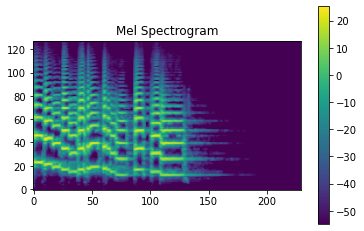

In [12]:
plt.imshow(S, origin="lower")
plt.title("Mel Spectrogram")
plt.colorbar()
plt.show()

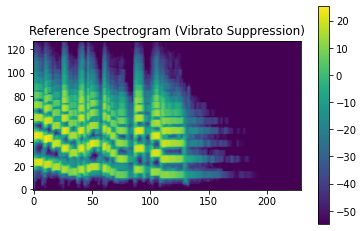

In [13]:
plt.imshow(ref, origin="lower")
plt.title("Reference Spectrogram (Vibrato Suppression)")
plt.colorbar()
plt.show()

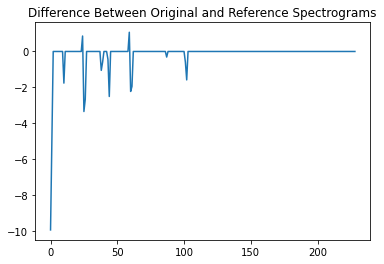

In [14]:
plt.plot(onset_env1[0])
plt.title("Difference Between Original and Reference Spectrograms")
plt.show()

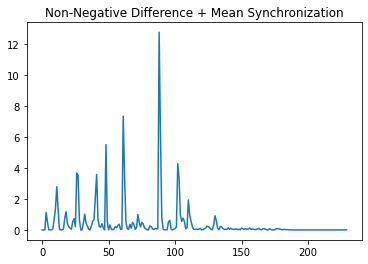

In [15]:
plt.plot(onset_env[0])
plt.title("Non-Negative Difference + Mean Synchronization")

plt.show()

In [16]:
onset_envelope = onset_env[0]
hop_length = 512
backtrack = False
energy = None
units = "times"
normalize = True
kwargs = {}

In [17]:
# Shift onset envelope up to be non-negative
# (a common normalization step to make the threshold more consistent)
if normalize:
    # Normalize onset strength function to [0, 1] range
    onset_envelope = onset_envelope - onset_envelope.min()
    # Max-scale with safe division
    onset_envelope /= np.max(onset_envelope) + util.tiny(onset_envelope)
    onset_envelope4 = onset_envelope

# Do we have any onsets to grab?
if not onset_envelope.any() or not np.all(np.isfinite(onset_envelope)):
    onsets = np.array([], dtype=np.int)

else:
    # These parameter settings found by large-scale search
    kwargs.setdefault("pre_max", 0.03 * sr // hop_length)  # 30ms
    kwargs.setdefault("post_max", 0.00 * sr // hop_length + 1)  # 0ms
    kwargs.setdefault("pre_avg", 0.10 * sr // hop_length)  # 100ms
    kwargs.setdefault("post_avg", 0.10 * sr // hop_length + 1)  # 100ms
    kwargs.setdefault("wait", 0.03 * sr // hop_length)  # 30ms
    kwargs.setdefault("delta", 0.07)

    # Peak pick the onset envelope
    onsets = util.peak_pick(onset_envelope, **kwargs)

    # Optionally backtrack the events
    if backtrack:
        if energy is None:
            energy = onset_envelope

        onsets = onset_backtrack(onsets, energy)

if units == "frames":
    pass
elif units == "samples":
    onsets = core.frames_to_samples(onsets, hop_length=hop_length)
elif units == "time":
    onsets = core.frames_to_time(onsets, hop_length=hop_length, sr=sr)

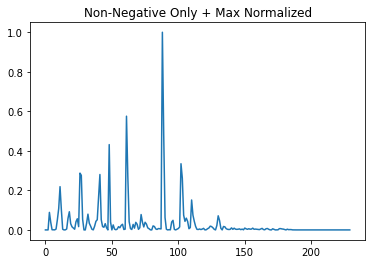

In [18]:
plt.plot(onset_envelope4)
plt.title("Non-Negative Only + Max Normalized")
plt.show()

# Peak Picking

In [19]:
def valid_int(x, cast=None):
    """Ensure that an input value is integer-typed.
    This is primarily useful for ensuring integrable-valued
    array indices.

    Parameters
    ----------
    x : number
        A scalar value to be cast to int

    cast : function [optional]
        A function to modify ``x`` before casting.
        Default: `np.floor`

    Returns
    -------
    x_int : int
        ``x_int = int(cast(x))``

    Raises
    ------
    ParameterError
        If ``cast`` is provided and is not callable.
    """

    if cast is None:
        cast = np.floor

    if not callable(cast):
        raise ParameterError("cast parameter must be callable")

    return int(cast(x))

In [20]:
x = onset_envelope
pre_max = kwargs["pre_max"]
post_max = kwargs["post_max"]
pre_avg = kwargs["pre_avg"]
post_avg = kwargs["post_avg"]
delta = kwargs["delta"]
wait = kwargs["wait"]

In [21]:
wait

1.0

In [22]:
# Ensure valid index types
pre_max = valid_int(pre_max, cast=np.ceil)
post_max = valid_int(post_max, cast=np.ceil)
pre_avg = valid_int(pre_avg, cast=np.ceil)
post_avg = valid_int(post_avg, cast=np.ceil)
wait = valid_int(wait, cast=np.ceil)

# Get the maximum of the signal over a sliding window
max_length = pre_max + post_max
max_origin = np.ceil(0.5 * (pre_max - post_max))
# Using mode='constant' and cval=x.min() effectively truncates
# the sliding window at the boundaries
mov_max = scipy.ndimage.filters.maximum_filter1d(
    x, int(max_length), mode="constant", origin=int(max_origin), cval=x.min()
)

# Get the mean of the signal over a sliding window
avg_length = pre_avg + post_avg
avg_origin = np.ceil(0.5 * (pre_avg - post_avg))
# Here, there is no mode which results in the behavior we want,
# so we'll correct below.
mov_avg = scipy.ndimage.filters.uniform_filter1d(
    x, int(avg_length), mode="nearest", origin=int(avg_origin)
)

# Correct sliding average at the beginning
n = 0
# Only need to correct in the range where the window needs to be truncated
while n - pre_avg < 0 and n < x.shape[0]:
    # This just explicitly does mean(x[n - pre_avg:n + post_avg])
    # with truncation
    start = n - pre_avg
    start = start if start > 0 else 0
    mov_avg[n] = np.mean(x[start : n + post_avg])
    n += 1
# Correct sliding average at the end
n = x.shape[0] - post_avg
# When post_avg > x.shape[0] (weird case), reset to 0
n = n if n > 0 else 0
while n < x.shape[0]:
    start = n - pre_avg
    start = start if start > 0 else 0
    mov_avg[n] = np.mean(x[start : n + post_avg])
    n += 1

# First mask out all entries not equal to the local max
detections = x * (x == mov_max)
detect1 = detections
# Then mask out all entries less than the thresholded average
detections = detections * (detections >= (mov_avg + delta))

# Initialize peaks array, to be filled greedily
peaks = []

# Remove onsets which are close together in time
last_onset = -np.inf

for i in np.nonzero(detections)[0]:
    # Only report an onset if the "wait" samples was reported
    if i > last_onset + wait:
        peaks.append(i)
        # Save last reported onset
        last_onset = i

Text(0.5, 1.0, 'Local Max')

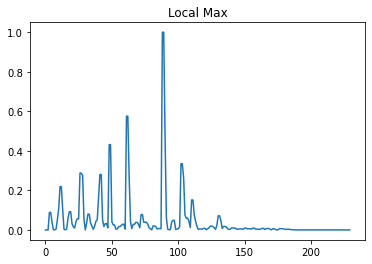

In [23]:
plt.plot(mov_max)
plt.title("Local Max")

Text(0.5, 1.0, 'Local Moving Average')

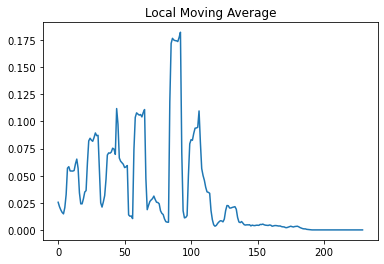

In [24]:
plt.plot(mov_avg)
plt.title("Local Moving Average")

Text(0.5, 1.0, 'Filtered Onset Candidates by Local Max and Moving Mean')

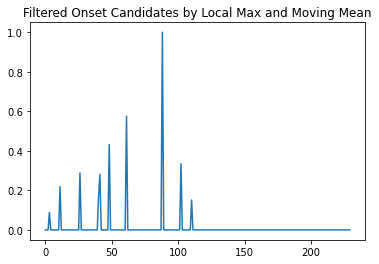

In [31]:
plt.plot(detections)
plt.title("Filtered Onset Candidates by Local Max and Moving Mean")

Text(0.5, 1.0, 'Selected Peaks')

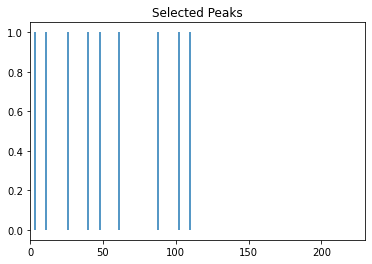

In [32]:
plt.vlines(peaks, ymin=0, ymax=1)
plt.xlim(0, len(detections))
plt.title("Selected Peaks")

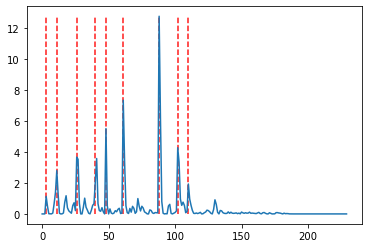

In [27]:
plt.plot(onset_env[0], label="Onset strength")
plt.vlines(
    peaks, 0, onset_env[0].max(), color="r", alpha=0.9, linestyle="--", label="Onsets"
)

In [28]:
o_env = librosa.onset.onset_strength(y, sr=sr, max_size=5)

times = librosa.times_like(o_env, sr=sr)

onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

Text(0, 0.5, 'Strength')

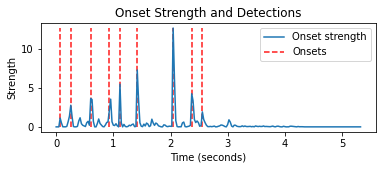

In [29]:
plt.figure(figsize=(6, 2))

plt.plot(times, o_env, label="Onset strength")

plt.vlines(
    times[onset_frames],
    0,
    o_env.max(),
    color="r",
    alpha=0.9,
    linestyle="--",
    label="Onsets",
)

plt.legend()
plt.title("Onset Strength and Detections")
plt.xlabel("Time (seconds)")
plt.ylabel("Strength")

In [30]:
# First mask out all entries not equal to the local max
detections = x * (x == mov_max)

# Then mask out all entries less than the thresholded average
detections = detections * (detections >= (mov_avg + delta))

# Initialize peaks array, to be filled greedily
peaks = []

# Remove onsets which are close together in time
last_onset = -np.inf

for i in np.nonzero(detections)[0]:
    # Only report an onset if the "wait" samples was reported
    if i > last_onset + wait:
        peaks.append(i)
        # Save last reported onset
        last_onset = i